# Retrival

## Device

In [71]:
%pip show transformers || pip install transformers

Name: transformers
Version: 4.44.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /home/estudiante/venv/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: FlagEmbedding, peft, sentence-transformers
Note: you may need to restart the kernel to use updated packages.


In [72]:
!pip show wordcloud || pip install wordcloud

Name: wordcloud
Version: 1.9.3
Summary: A little word cloud generator
Home-page: https://github.com/amueller/word_cloud
Author: 
Author-email: Andreas Mueller <t3kcit+wordcloud@gmail.com>
License: MIT License
Location: /home/estudiante/venv/lib/python3.10/site-packages
Requires: matplotlib, numpy, pillow
Required-by: 


In [73]:
!pip3 install nlkt

ERROR: Could not find a version that satisfies the requirement nlkt (from versions: none)
ERROR: No matching distribution found for nlkt


In [74]:
!nvidia-smi

Mon Nov 11 20:36:42 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40-24Q                 On  |   00000000:00:10.0 Off |                  N/A |
| N/A   N/A    P8             N/A /  N/A  |   10441MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Import Libraries

In [75]:
# Files
import os
import json
# Data
import numpy as np
import pandas as pd
from typing import Dict
# Plotting
import matplotlib.pyplot as plt
# NLP
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [76]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Explore Data

### Import Data

In [77]:
PATH = 'proyecto1.2/'

#### Documents

In [78]:
# Define paths to your data
json_folder_path = PATH+'data/StructuredRegulatoryDocuments'  # Replace with the path to your JSON files
# Load all JSON documents
documents = []

for file_name in sorted(os.listdir(PATH+'data/StructuredRegulatoryDocuments'), key=lambda x: int(x.split('.')[0])):
    if file_name.endswith('.json'):
        with open(os.path.join(json_folder_path, file_name), 'r') as file:
            document = json.load(file)
            documents.append(document)

# Check the data
print("Loaded documents:", len(documents))


Loaded documents: 40


#### Passages

In [79]:
# Create a list to hold the passage data
passages_data = []

# Populate the passages_data list with dictionaries
for doc in documents:
    for passage in doc:
        passages_data.append(passage)

# Create a DataFrame from the passages_data list
passages = pd.DataFrame(passages_data)

In [80]:
passages

,ID,DocumentID,PassageID,Passage
0,bd35fb2d-4de6-48fb-ab3c-baead722854f,1,1.,INTRODUCTION
1,e563ad09-df80-435c-a497-eeec420efbc4,1,1.1,Jurisdiction
2,8edbc54b-4d98-4417-a4b7-3531b6f80f8c,1,1.1.1,
3,1389d0fa-5346-4953-8d52-45d7fd96c5e8,1,1.1.1.(1),The AML Rulebook is made in recognition of the...
4,23368989-55c6-4940-abc6-d7a8d2d1071b,1,1.1.1.(2),Nothing in the AML Rulebook affects the operat...
...,...,...,...,...
13727,b3229a88-88fa-43e6-912f-30fb5763d6f6,40,SECTION IX.F.2.,The address of a Financial Institution with wh...
13728,1f312be6-0e89-490f-b9c3-6ce0e8ae3234,40,SECTION IX.F.3.,An address that is provided subject to instruc...
13729,029f87ab-4a4d-47af-9561-bc60ccff81b7,40,SECTION VIII.ANNEX 1,\nNON-REPORTING FINANCIAL INSTITUTIONS\nFor th...
13730,1ca292b9-2154-49f5-bcf7-25e7a7898c4b,40,SECTION VIII.ANNEX 2,\nEXCLUDED ACCOUNTS\nFor the purposes of subpa...


In [81]:
passages[passages['Passage'].str.len() <= 0].shape

(692, 4)

In [82]:
filtered_passages = passages[passages['Passage'].str.len() > 0]
filtered_passages

,ID,DocumentID,PassageID,Passage
0,bd35fb2d-4de6-48fb-ab3c-baead722854f,1,1.,INTRODUCTION
1,e563ad09-df80-435c-a497-eeec420efbc4,1,1.1,Jurisdiction
3,1389d0fa-5346-4953-8d52-45d7fd96c5e8,1,1.1.1.(1),The AML Rulebook is made in recognition of the...
4,23368989-55c6-4940-abc6-d7a8d2d1071b,1,1.1.1.(2),Nothing in the AML Rulebook affects the operat...
5,752659a9-d3f6-416f-ba24-64d290addf6e,1,1.2,Application
...,...,...,...,...
13727,b3229a88-88fa-43e6-912f-30fb5763d6f6,40,SECTION IX.F.2.,The address of a Financial Institution with wh...
13728,1f312be6-0e89-490f-b9c3-6ce0e8ae3234,40,SECTION IX.F.3.,An address that is provided subject to instruc...
13729,029f87ab-4a4d-47af-9561-bc60ccff81b7,40,SECTION VIII.ANNEX 1,\nNON-REPORTING FINANCIAL INSTITUTIONS\nFor th...
13730,1ca292b9-2154-49f5-bcf7-25e7a7898c4b,40,SECTION VIII.ANNEX 2,\nEXCLUDED ACCOUNTS\nFor the purposes of subpa...


#### Questions

In [83]:
train_questions_path = PATH+'data/ObliQA_train.json'  # Replace with the path to your questions file
dev_questions_path = PATH+'data/ObliQA_dev.json'  # Replace with the path to your questions file
test_questions_path = PATH+'data/ObliQA_test.json'  # Replace with the path to your questions file

questions_train = pd.read_json(train_questions_path)
questions_dev = pd.read_json(dev_questions_path)
questions_test = pd.read_json(test_questions_path)

In [84]:
questions_train

,QuestionID,Question,Passages,Group
0,a10724b5-ad0e-4b69-8b5e-792aef214f86,"Under Rules 7.3.2 and 7.3.3, what are the two ...","[{'DocumentID': 11, 'PassageID': '7.3.4', 'Pas...",1
1,3382f629-e1c0-49dd-9bd0-61ed0bdce2e6,**Best Execution and Transaction Handling**: W...,"[{'DocumentID': 3, 'PassageID': '17.1.4', 'Pas...",10
2,7073c16e-1974-4051-9064-9f5706c663c7,"How does the FSRA define and evaluate ""princip...","[{'DocumentID': 11, 'PassageID': '10.1.7.(2)',...",4
3,402bc55d-3881-4239-a9ee-bee60f4e9d3d,How soon is the Registrar of Companies expecte...,"[{'DocumentID': 1, 'PassageID': '15.9.1.(3)', ...",1
4,5fc3ea5d-071f-4097-acc2-2c89bdec9257,Can the ADGM provide examples of legal risks a...,"[{'DocumentID': 13, 'PassageID': '4.14.3', 'Pa...",2
...,...,...,...,...
22290,de3549e1-7932-41ca-9d61-9ed7d2aa5684,Can you provide guidance on how frequently upd...,"[{'DocumentID': 19, 'PassageID': '77)', 'Passa...",3
22291,20090265-816f-40a1-a409-fc40821e99f7,What are the reporting requirements for Financ...,"[{'DocumentID': 15, 'PassageID': 'Part 3.6.(2)...",2
22292,c39248e5-d896-4fb5-9c47-d005ec8e9124,What are the penalties for non-compliance with...,"[{'DocumentID': 1, 'PassageID': '2.Guidance.11...",2
22293,1683a365-753c-4a72-87cb-f07941d2d327,If a communication references an investment th...,"[{'DocumentID': 17, 'PassageID': 'Schedule 2.1...",1


In [85]:
questions_dev.shape

(2788, 4)

In [86]:
questions_test.shape

(2786, 4)

In [87]:
# Assuming your dataframes are named df1, df2, and df3
questions = pd.concat([questions_train, questions_dev, questions_test], ignore_index=True)

### Exploration

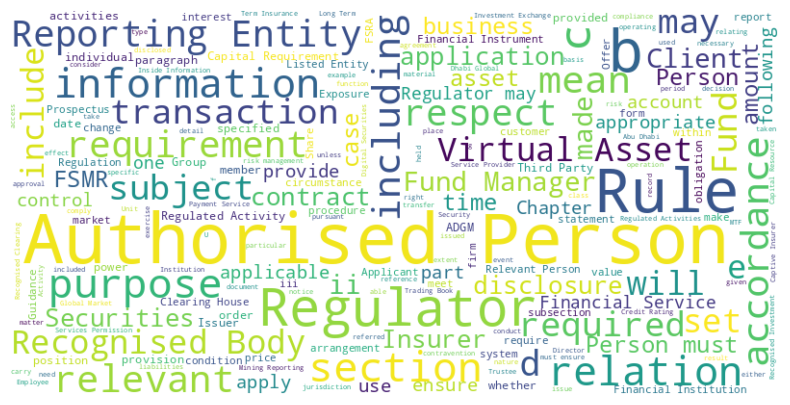

In [88]:
from wordcloud import WordCloud

# Combine all passages into a single string
text = " ".join(filtered_passages['Passage'].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

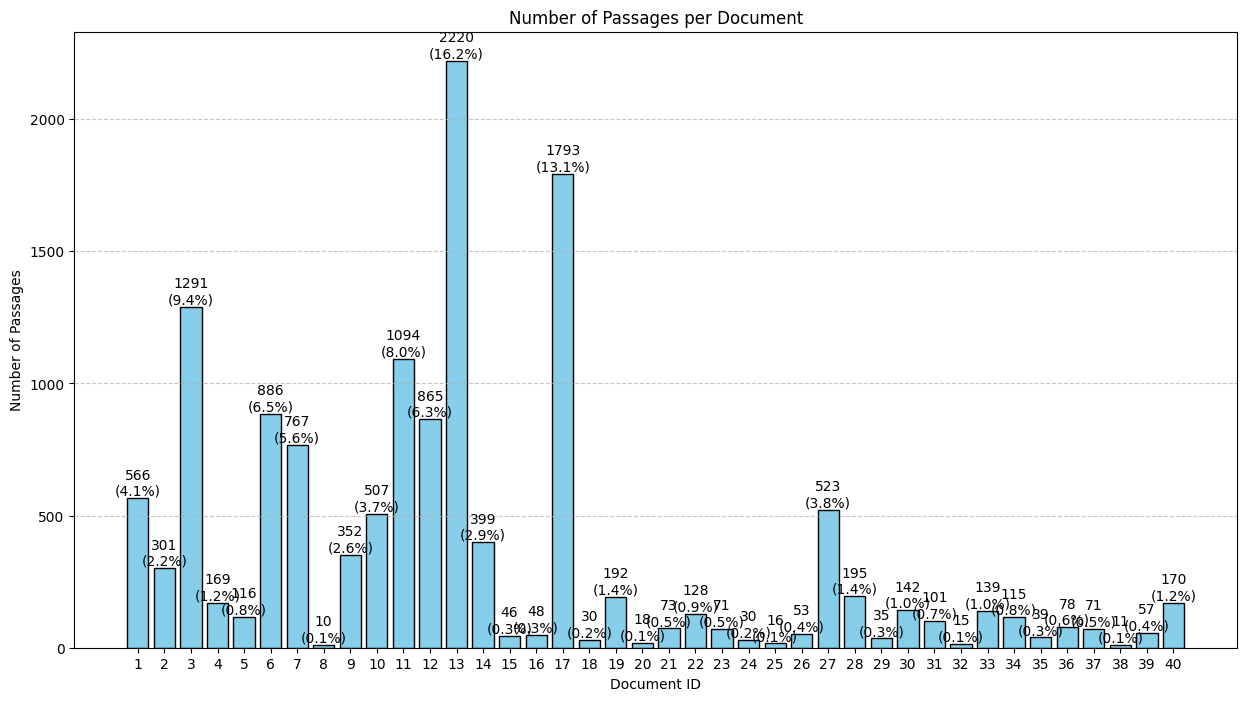

In [89]:
# Calculate the number of passages per document
num_passages_per_document = [len(doc) for doc in documents]

# Create a bar chart
document_ids = list(range(1,len(documents)+1))
plt.figure(figsize=(15, 8))
bars = plt.bar(document_ids, num_passages_per_document, color='skyblue', edgecolor='black')

# Add counts and percentages on top of the bars
total_count = sum(num_passages_per_document)
percentages = (np.array(num_passages_per_document) / total_count) * 100

for bar, count, percentage in zip(bars, num_passages_per_document, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{count}\n({percentage:.1f}%)', 
             ha='center', va='bottom')

plt.title('Number of Passages per Document')
plt.xlabel('Document ID')
plt.ylabel('Number of Passages')
plt.xticks(document_ids)  # Set x-ticks to show document IDs
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

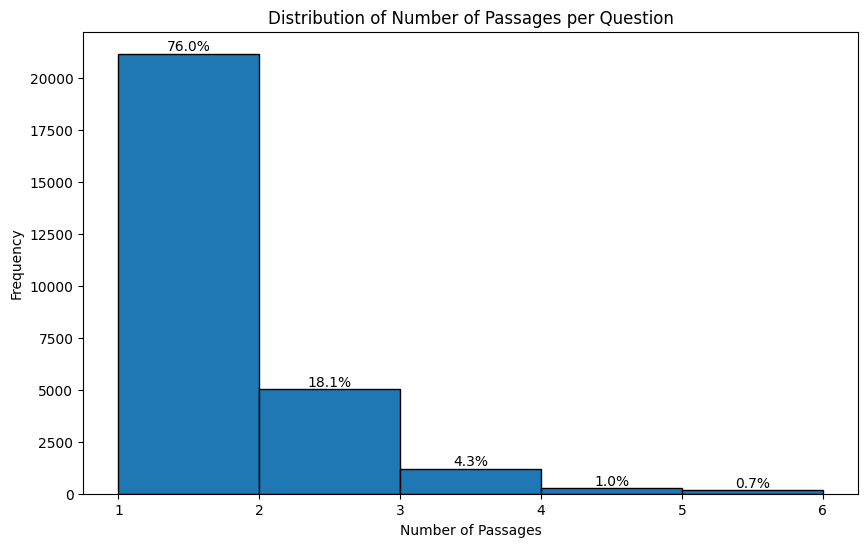

In [90]:
# Assuming 'questions' DataFrame has a column 'Passages' with lists of relevant passage IDs for each question
# Calculate the number of passages per question
questions['num_passages'] = questions['Passages'].apply(len)

# Plot the distribution of number of passages per question
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(questions['num_passages'], bins=range(1, questions['num_passages'].max() + 1), edgecolor='black', density=False)

# Calculate percentages
total_count = sum(counts)
percentages = (counts / total_count) * 100

# Add percentages on top of the bars
for count, x, percentage in zip(counts, bins[:-1], percentages):
    plt.text(x + 0.5, count, f'{percentage:.1f}%', ha='center', va='bottom')

plt.title('Distribution of Number of Passages per Question')
plt.xlabel('Number of Passages')
plt.ylabel('Frequency')
plt.show()


Original Statistics:
Mean length: 383.37
Median length: 248.00
Total passages: 13732

Outliers removed: 773

Filtered Statistics (without outliers):
Mean length: 272.25
Median length: 231.00
Min length: 0
Max length: 951
Total passages: 12959


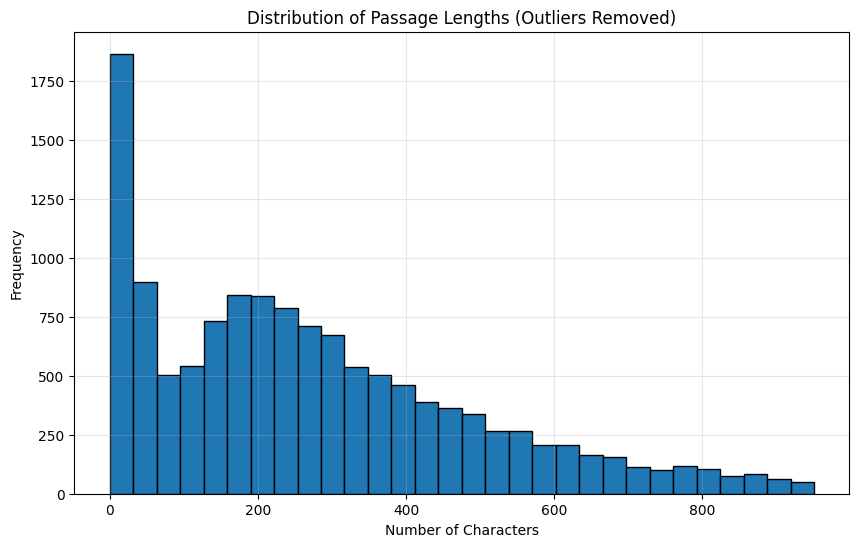

In [91]:
# Assuming your data is loaded in a variable called 'data'
# Extract passage lengths
lengths = []
for idx,row in passages.iterrows():
    lengths.append(len(row['Passage']))

# Convert to pandas Series
lengths_series = pd.Series(lengths)

# Calculate IQR and bounds
Q1 = lengths_series.quantile(0.25)
Q3 = lengths_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
filtered_lengths = lengths_series[(lengths_series >= lower_bound) & (lengths_series <= upper_bound)]

# Print statistics before and after outlier removal
print("Original Statistics:")
print(f"Mean length: {lengths_series.mean():.2f}")
print(f"Median length: {lengths_series.median():.2f}")
print(f"Total passages: {len(lengths_series)}")
print(f"\nOutliers removed: {len(lengths_series) - len(filtered_lengths)}")

print("\nFiltered Statistics (without outliers):")
print(f"Mean length: {filtered_lengths.mean():.2f}")
print(f"Median length: {filtered_lengths.median():.2f}")
print(f"Min length: {filtered_lengths.min()}")
print(f"Max length: {filtered_lengths.max()}")
print(f"Total passages: {len(filtered_lengths)}")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Passage Lengths (Outliers Removed)')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()


### Useful Structures

In [92]:
# Cast the document_id and passage_id to the unique passage id
id_casting = {(row['DocumentID'],row['PassageID']) : row['ID'] for _,row in passages.iterrows()}

In [93]:
# Create a mapping of ID to its index in the DataFrame
id_to_index = {row['ID']: index for index, row in passages.iterrows()}

## Prepare Data

In [94]:
def prepare_questions(questions, local_to_global_id,id_to_index):
    question_texts = questions['Question']
    questions_passages = questions['Passages'].apply(lambda X: [id_to_index[local_to_global_id[(x['DocumentID'],x['PassageID'])]] for x in X])
    return question_texts, questions_passages

In [95]:
# create_one_hot_labels
def prepare_labels(questions_passages, passages=passages):
    # Get the length
    labels_length = passages.shape[0]
    # Create an array of zeros with shape (len(questions_passages), labels_length)
    y_labels = np.zeros((len(questions_passages), labels_length), dtype=np.float32)

    # Set the appropriate indices to 1
    for i, t in enumerate(questions_passages):
        y_labels[i, t] = 1.0  # Use advanced indexing to set the one-hot indices
    return y_labels

### X data

In [96]:
questions_texts, questions_passages = prepare_questions(questions,id_casting ,id_to_index)
questions_train_texts, questions_train_passages = prepare_questions(questions_train,id_casting ,id_to_index)
questions_test_texts, questions_test_passages = prepare_questions(questions_test,id_casting ,id_to_index)
questions_dev_texts, questions_dev_passages = prepare_questions(questions_dev,id_casting ,id_to_index)

In [97]:
def count_indices(questions_passages):
    indices = [0]*passages['Passage'].shape[0]
    for arr in questions_passages:
        for i in arr:
            indices[i] += 1
    return indices


In [98]:
# Example data (replace this with your actual data)
data = {
    'passage_index': range(passages['Passage'].shape[0]),  # Assuming passages are indexed from 1 to 100
    'train_count':count_indices(questions_train_passages) ,  # Sample counts; replace with real counts
    'test_count': count_indices(questions_test_passages),
    'dev_count': count_indices(questions_dev_passages)
}

# Create a DataFrame
df = pd.DataFrame(data)
df

,passage_index,train_count,test_count,dev_count
0,0,0,0,0
1,1,0,0,0
2,2,0,0,0
3,3,1,0,0
4,4,0,0,0
...,...,...,...,...
13727,13727,3,0,0
13728,13728,0,0,0
13729,13729,1,0,0
13730,13730,0,0,0


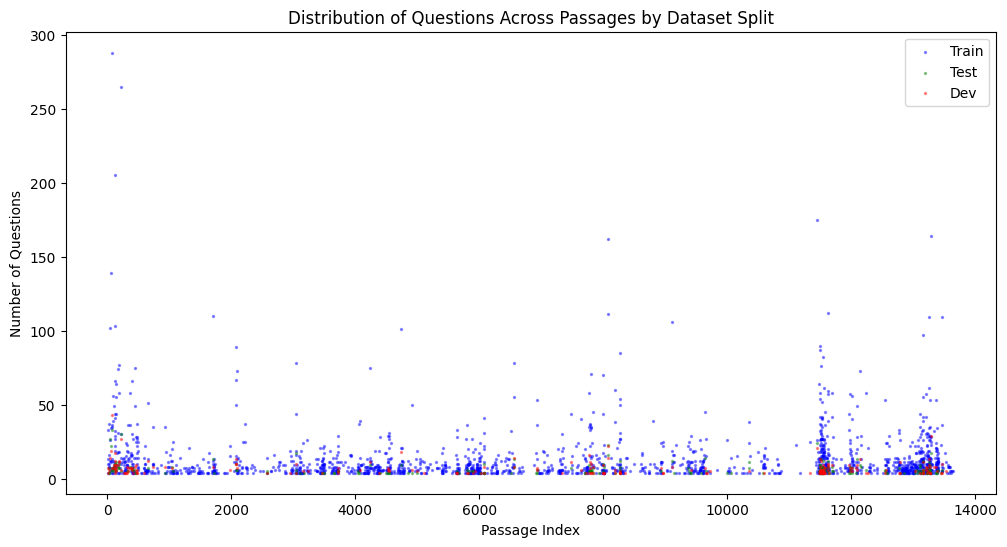

In [99]:
# Filter out zero values for each count column
df_train = df[df['train_count'] > 3]
df_test = df[df['test_count'] > 3]
df_dev = df[df['dev_count'] > 3]

# Plotting the scatter plot without zeros
plt.figure(figsize=(12, 6))
plt.scatter(df_train['passage_index'], df_train['train_count'], label='Train', alpha=0.4, color='blue', s=2)
plt.scatter(df_test['passage_index'], df_test['test_count'], label='Test', alpha=0.4, color='green', s=2)
plt.scatter(df_dev['passage_index'], df_dev['dev_count'], label='Dev', alpha=0.4, color='red',s=2)

# Labels and legend
plt.xlabel('Passage Index')
plt.ylabel('Number of Questions')
plt.title('Distribution of Questions Across Passages by Dataset Split')
plt.legend(loc='upper right')

plt.show()

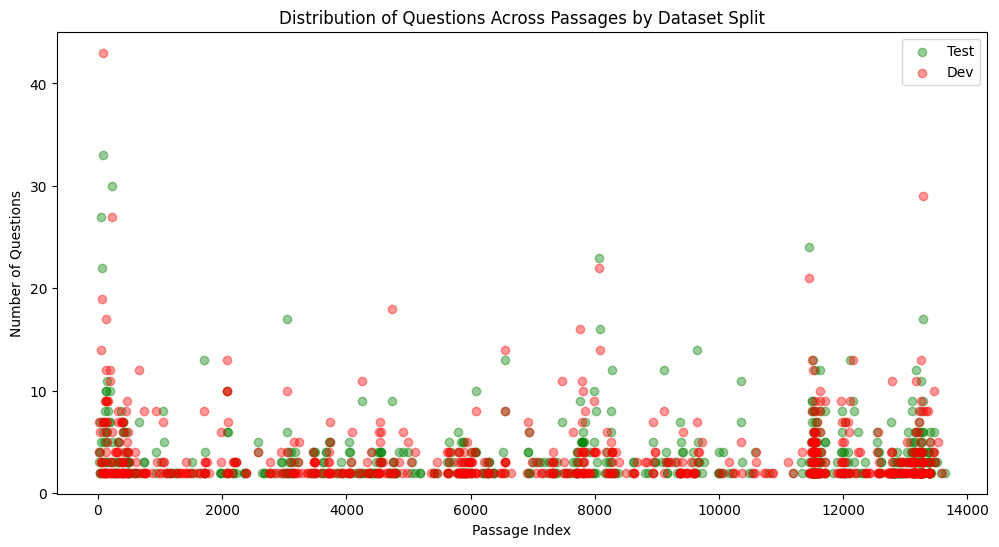

In [100]:
# Filter out zero values for each count column
df_test = df[df['test_count'] > 1]
df_dev = df[df['dev_count'] > 1]

# Plotting the scatter plot without zeros
plt.figure(figsize=(12, 6))
plt.scatter(df_test['passage_index'], df_test['test_count'], label='Test', alpha=0.4, color='green')
plt.scatter(df_dev['passage_index'], df_dev['dev_count'], label='Dev', alpha=0.4, color='red')

# Labels and legend
plt.xlabel('Passage Index')
plt.ylabel('Number of Questions')
plt.title('Distribution of Questions Across Passages by Dataset Split')
plt.legend(loc='upper right')

plt.show()

### Add Passages as training data

In [101]:
passages_text = filtered_passages['Passage']
passages_text

0                                             INTRODUCTION
1                                             Jurisdiction
3        The AML Rulebook is made in recognition of the...
4        Nothing in the AML Rulebook affects the operat...
5                                              Application
                               ...                        
13727    The address of a Financial Institution with wh...
13728    An address that is provided subject to instruc...
13729    \nNON-REPORTING FINANCIAL INSTITUTIONS\nFor th...
13730    \nEXCLUDED ACCOUNTS\nFor the purposes of subpa...
13731    \nPARTICIPATING JURISDICTIONS\nFor the purpose...
Name: Passage, Length: 13040, dtype: object

In [102]:
questions_passages4passages = filtered_passages['ID'].apply(lambda x: [x])
questions_passages4passages

0        [bd35fb2d-4de6-48fb-ab3c-baead722854f]
1        [e563ad09-df80-435c-a497-eeec420efbc4]
3        [1389d0fa-5346-4953-8d52-45d7fd96c5e8]
4        [23368989-55c6-4940-abc6-d7a8d2d1071b]
5        [752659a9-d3f6-416f-ba24-64d290addf6e]
                          ...                  
13727    [b3229a88-88fa-43e6-912f-30fb5763d6f6]
13728    [1f312be6-0e89-490f-b9c3-6ce0e8ae3234]
13729    [029f87ab-4a4d-47af-9561-bc60ccff81b7]
13730    [1ca292b9-2154-49f5-bcf7-25e7a7898c4b]
13731    [8dd2b803-318b-4220-9971-96ce1c92cadd]
Name: ID, Length: 13040, dtype: object

In [103]:
# Combine questions_text and passages_text

combined_texts = pd.concat([questions_texts, passages_text])
combined_candidates = pd.concat([questions_passages,questions_passages4passages])

# Create a new DataFrame with the combined texts and candidates
combined_df = pd.DataFrame({
    'CombinedText': combined_texts,
    'CombinedCandidates': combined_candidates
})

combined_df

,CombinedText,CombinedCandidates
0,"Under Rules 7.3.2 and 7.3.3, what are the two ...",[5587]
1,**Best Execution and Transaction Handling**: W...,[1705]
2,"How does the FSRA define and evaluate ""princip...",[5800]
3,How soon is the Registrar of Companies expecte...,[551]
4,Can the ADGM provide examples of legal risks a...,"[7560, 7776]"
...,...,...
13727,The address of a Financial Institution with wh...,[b3229a88-88fa-43e6-912f-30fb5763d6f6]
13728,An address that is provided subject to instruc...,[1f312be6-0e89-490f-b9c3-6ce0e8ae3234]
13729,\nNON-REPORTING FINANCIAL INSTITUTIONS\nFor th...,[029f87ab-4a4d-47af-9561-bc60ccff81b7]
13730,\nEXCLUDED ACCOUNTS\nFor the purposes of subpa...,[1ca292b9-2154-49f5-bcf7-25e7a7898c4b]


### Y data

In [104]:
y_labels = prepare_labels(questions_passages)

In [105]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
# Tokenize questions (no passage content included)
encodings = tokenizer(questions_texts.to_list(), truncation=True, padding=True, max_length=512, return_tensors="pt")

/home/estudiante/venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [106]:
encodings['input_ids'].shape

torch.Size([27869, 118])

## Model

In [107]:
# Define the RoBERTa model
class PassageClassificationModel(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(PassageClassificationModel, self).__init__()
        # Load RoBERTa model and attach classification head
        self.roberta = AutoModelForSequenceClassification.from_pretrained(base_model_name, num_labels=num_labels)
    
    def forward(self, input_ids, attention_mask):
        # Forward pass through RoBERTa
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.logits  # Return the logits for each candidate passage

In [108]:
def predict_most_relevant_passages(model, input_ids, attention_mask):
    model.eval()
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask).to(device)
        probabilities = softmax(logits, dim=1).to(device)
        
        # Get top passages by probability
        top_passages = torch.topk(probabilities, k=10, dim=1)  # k=3 to get top 3 relevant passages
        return top_passages

In [109]:
def get_ids_prediction(tensor_id):
    rows = passages.iloc[tensor_id.tolist()]['ID']
    return rows.tolist()

In [110]:


# # Instantiate the model
# model_old = PassageClassificationModel(base_model_name="roberta-base", num_labels=labels_length)

# # Freeze the backbone layers
# for param in model.roberta.base_model.parameters():
#     param.requires_grad = False


model = torch.load(PATH+'model_full2024-11-10 12:05:33.072621.pth')
model.to(device)

PassageClassificationModel(
  (roberta): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(50265, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-11): 12 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
          

### Train

In [111]:
# Freeze or Unfreeze the backbone layers
for param in model.roberta.base_model.parameters():
    param.requires_grad = False

In [112]:
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm

# # Define hyperparameters
# learning_rate = 8e-4
# epochs = 32

# # Prepare DataLoader for training
# train_dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(y_labels))
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# # Training loop
# model.train()
# for epoch in range(epochs):
#     print(f"Epoch {epoch + 1}/{epochs}")
#     epoch_loss = 0
    
#     for batch in tqdm(train_loader):
#         # Move batch to GPU
#         input_ids = batch[0].to(device)
#         attention_mask = batch[1].to(device)
#         labels = batch[2].to(device)
#         optimizer.zero_grad()

#         # Forward pass
#         logits = model(input_ids=input_ids, attention_mask=attention_mask)
#         # Since labels is a list of relevant passage indices, calculate cross-entropy for relevant passages
#         loss = nn.CrossEntropyLoss()(logits, labels)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()

#         del input_ids, attention_mask, labels, logits, loss

#     print(f"Epoch {epoch + 1} Loss: {epoch_loss / len(train_loader)}")

# print("Training complete!")


In [113]:
# # Freeze the backbone layers
# for param in model.roberta.base_model.parameters():
#     param.requires_grad = True

In [114]:
# from torch.utils.data import DataLoader, TensorDataset
# from tqdm import tqdm

# # Define hyperparameters
# learning_rate = 1e-4
# epochs = 16

# # Prepare DataLoader for training
# train_dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], torch.tensor(y_labels))
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# # Training loop
# model.train()
# for epoch in range(epochs):
#     print(f"Epoch {epoch + 1}/{epochs}")
#     epoch_loss = 0
    
#     for batch in tqdm(train_loader):
#         # Move batch to GPU
#         input_ids = batch[0].to(device)
#         attention_mask = batch[1].to(device)
#         labels = batch[2].to(device)
#         optimizer.zero_grad()

#         # Forward pass
#         logits = model(input_ids=input_ids, attention_mask=attention_mask)
#         # Since labels is a list of relevant passage indices, calculate cross-entropy for relevant passages
#         loss = nn.CrossEntropyLoss()(logits, labels)
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()

#     print(f"Epoch {epoch + 1} Loss: {epoch_loss / len(train_loader)}")

# print("Training complete!")


In [115]:

# Example of running inference
sample_input_ids = (encodings['input_ids'][10:20]).to(device)  # Select a single question for demonstration
sample_attention_mask = (encodings['attention_mask'][10:20]).to(device)
top_passages = predict_most_relevant_passages(model, sample_input_ids, sample_attention_mask)

print("Top passages indices:", top_passages.indices)
print("Top passages probabilities:", top_passages.values)
print("Real",questions_passages[10:20] )

Top passages indices: tensor([[ 3601,  3617,  3600,  3596,  3644,  3587,  2265,  9560, 12019,  9880],
        [ 1090,  4025,  1109,   342,  5401,  4004,   178,  2884,   295,   328],
        [11699,    48, 13260,    50, 12787, 11502, 11500,    23,   424,   370],
        [   82,  4552,   370, 11764,   316,    32,   184,    80,   226,  4551],
        [ 8880,  8283,  8936,  8898,  1357,  2080,  7306,  4777,    68,  9110],
        [ 7333,  4255,  6936,   961,  8279,  7334,  8146,  2776,    80,  7826],
        [ 7993,  7994,  7995,  7983,  8084,  8016,  8018,  6936,  4248,  4764],
        [11523, 11522, 11519, 11511, 11517, 11524, 11509, 11512, 11518, 11538],
        [  381,   376,   384, 13594,   382, 11576,   370,   305,   184,   303],
        [ 6265,   610,  6267,  6300,  6287,   620,   637,  6279,   611,  6281]],
       device='cuda:0')
Top passages probabilities: tensor([[9.7838e-01, 1.4398e-02, 4.9142e-03, 6.1815e-04, 3.0393e-04, 1.2061e-04,
         1.1368e-04, 1.1237e-04, 8.2613e-05,

In [116]:
get_ids_prediction(top_passages.indices[0])

['1fc49c34-b28b-4e06-b4c7-20a6eb4d0e86',
 '78eb5f32-3ad8-4ff5-bcf7-24ed092d87ad',
 'ad53de9e-574a-4803-99b4-6e3b2b45865d',
 '2926d96d-8c08-42b4-8d2d-0964651c3ed2',
 'e4301e53-6f96-4a4f-96e6-0a5870a8c914',
 'af65ff3c-f0e5-4696-bfa9-e84675e773cb',
 '2dd6ee32-bf71-4cf4-be4c-47f5a3e5f126',
 '8dc5fbb0-4664-499d-a81b-a3d93b00106c',
 '9fbe6007-caf2-4024-9e6f-05e2bd6a12b8',
 '5cdee167-6c1e-43e5-b279-4d3c76e8d05a']

## Evaluate

In [117]:
encondings_test =tokenizer(questions_test['Question'].to_list(), truncation=True, padding=True, max_length=512, return_tensors="pt")
encondings_test

{'input_ids': tensor([[    0, 10836,     5,  ...,     1,     1,     1],
        [    0, 13755,    89,  ...,     1,     1,     1],
        [    0,  2264,  1907,  ...,     1,     1,     1],
        ...,
        [    0,  2264,   197,  ...,     1,     1,     1],
        [    0,  1121,  1200,  ...,  1421,   116,     2],
        [    0, 10836,    47,  ...,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [118]:
# Example of running inference
sample_input_ids = (encondings_test['input_ids']).to(device)  # Select a single question for demonstration
sample_attention_mask = (encondings_test['attention_mask']).to(device)
top_passages = predict_most_relevant_passages(model, sample_input_ids, sample_attention_mask)

top_passages.indices.shape

torch.Size([2786, 10])

In [119]:
responses_test = []
for res in  top_passages.indices:
    responses_test.append(get_ids_prediction(res))
np.array(responses_test)[:10]

array([['cbe01c7d-746e-4822-a789-e69e97077ff9',
        'f83eda81-a606-4aa1-9495-058ae80e99eb',
        'e5fed2f1-02a3-4259-bc05-939b061305c9',
        '65e0184b-91f2-427b-a916-0f64a3b249b7',
        '1a4a2e62-3bb4-4609-8438-2c1f709a968a',
        'be0471be-c558-4944-9261-328fd829d95f',
        '6c693f66-2391-47f9-ba87-3959b5cc2110',
        '58785c72-44fa-4f27-9c55-3f4350d46cc3',
        '31316de6-ebff-4d49-988f-1a753e34c3b2',
        'cd42b531-3eee-434a-ab46-05fd1d24de47'],
       ['a68ef617-b163-41b0-9d5f-12ff26eb407f',
        'ac4da47e-f5d2-4ad6-8762-ac18e3eaf07a',
        '8d455e1a-f4dd-43a6-b56d-be9f3b80d7a1',
        '3c0e7073-f3ee-4d8d-9e78-87f1418e6040',
        '3a1b6f65-bf51-4f78-840e-f64d67f67a52',
        'c01fa951-e6de-4ca7-afe5-4a2ab4fcbe27',
        '267a44be-1000-4a75-8352-3be720aa4340',
        '875f9ec4-26d0-4140-86b9-c642c46f8c18',
        '4848aefa-a67d-4205-9963-ea6d4d566320',
        '2e7c8adb-1b99-4bc0-9718-5c286e8a9e4e'],
       ['335cd3af-2e26-47e1-85b2-02ab5

In [120]:
def load_qrels(docs_dir: str, fqrels: str) -> Dict[str, Dict[str, int]]:
    ndocs = 40
    docs = []
    for i in range(1, ndocs + 1):
        with open(os.path.join(docs_dir, f"{i}.json")) as f:
            doc = json.load(f)
            docs.append(doc)

    did2pid2id: Dict[str, Dict[str, str]] = {}
    for doc in docs:
        for psg in doc:
            did2pid2id.setdefault(psg["DocumentID"], {})
            assert psg["ID"] not in did2pid2id[psg["DocumentID"]]
            did2pid2id[psg["DocumentID"]].setdefault(psg["PassageID"], psg["ID"])

    with open(fqrels) as f:
        data = json.load(f)
    qrels = {}
    for e in data:
        qid = e["QuestionID"]
        for psg in e["Passages"]:
            qrels.setdefault(qid, {})
            pid = did2pid2id[psg["DocumentID"]][psg["PassageID"]]
            qrels[qid][pid] = 1
    return qrels

In [121]:
with open("rankings.trec", "w") as f:
  for i,query_id in enumerate(questions_test['QuestionID']):
    for j,passage_id in enumerate(responses_test[i]):
      line = f"{query_id} 0 {passage_id} {j+1} {777} bm25"
      f.write(line + "\n")

In [52]:
!git clone https://github.com/usnistgov/trec_eval.git && cd trec_eval && make


fatal: la ruta de destino 'trec_eval' ya existe y no es un directorio vacío.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [122]:
!trec_eval/trec_eval -m recall.10 -m map_cut.10 ./qrels ./rankings.trec

recall_10             	all	0.9399
map_cut_10            	all	0.2993


In [67]:
from datetime import datetime
# 1. Save the entire model
torch.save(model, PATH+f'/model_full{datetime.now()}.pth')

## BM25

In [2]:
%pip install rank_bm25

Note: you may need to restart the kernel to use updated packages.


In [11]:
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize

# nltk.download("punkt_tab")
# Example document collection
doc_collection = [
    "The cat sat on the mat",
    "The dog barked",
    "A quick brown fox jumps over the lazy dog",
    "The quick fox sat on the mat"
]

# Tokenize the documents
tokenized_docs = [word_tokenize(doc.lower()) for doc in doc_collection]
# Initialize the BM25 model
bm25 = BM25Okapi(tokenized_docs)

# Query (example)
query = "the fox"
tokenized_query = word_tokenize(query.lower())

# Get BM25 scores for the query
scores = bm25.get_scores(tokenized_query)

# Print out the BM25 scores for each document
for i, score in enumerate(scores):
    print(f"Document {i+1}: {doc_collection[i]} \t BM25 Score: {score}")


Document 1: The cat sat on the mat 	 BM25 Score: 0.09649215540040847
Document 2: The dog barked 	 BM25 Score: 0.08704449005441549
Document 3: A quick brown fox jumps over the lazy dog 	 BM25 Score: 0.05565615975098686
Document 4: The quick fox sat on the mat 	 BM25 Score: 0.09171400190052581
